In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

  Using cached torch-2.0.0-cp38-cp38-win_amd64.whl (172.3 MB)
  Using cached munch-3.0.0-py2.py3-none-any.whl (10 kB)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16431 sha256=0394f34ac1e9ee500a37d866c91a35cdebf91d0c685b5654c2e2e21616cd0756
  Stored in directory: c:\users\legion\appdata\local\pip\cache\wheels\84\b9\90\25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60948 sha256=7a1f25535f62ac965b9fd244a2e9896ea7e10a7efb79818bd1e242d2e9709570
  Stored in directory: c:\users\legion\appdata\local\pip\cache\wheels\ed\fa\b9\5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Attempting uninstall: timm
    Found existing installation: timm

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

ohmeow-blurr 1.0.5 requires torch<2.0.0,>=1.7.0, but you'll have torch 2.0.0 which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but you'll have torch 2.0.0 which is incompatible.
chromadb 0.3.22 requires numpy>=1.21.6, but you'll have numpy 1.21.0 which is incompatible.


  Cloning https://github.com/albumentations-team/albumentations to c:\users\legion\appdata\local\temp\pip-req-build-20gs4c92
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=126594 sha256=95f7f1523a7a9b2326afa3f280ba19a9706d1514c585e42e0ef0d771dc0d9bf0
  Stored in directory: C:\Users\Legion\AppData\Local\Temp\pip-ephem-wheel-cache-2e99g5l7\wheels\f3\4a\7f\67b055656bec4d4aaa8963cfc93678f6f2906b2d72054a1268
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


# The Modular Architecture of the Project

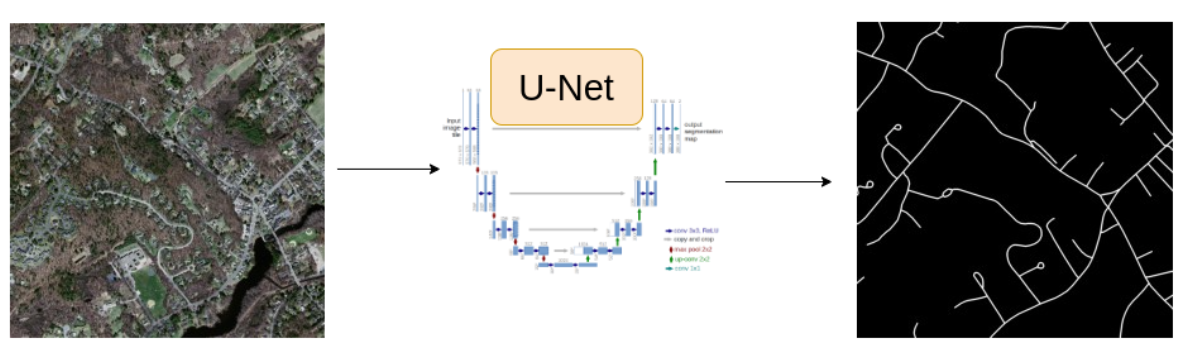

In [2]:
# download dataset
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
Updating files:  14% (60/401)
Updating files:  15% (61/401)
Updating files:  16% (65/401)
Updating files:  17% (69/401)
Updating files:  18% (73/401)
Updating files:  19% (77/401)
Updating files:  20% (81/401)
Updating files:  21% (85/401)
Updating files:  22% (89/401)
Updating files:  23% (93/401)
Updating files:  24% (97/401)
Updating files:  25% (101/401)
Updating files:  26% (105/401)
Updating files:  27% (109/401)
Updating files:  28% (113/401)
Updating files:  28% (115/401)
Updating files:  29% (117/401)
Updating files:  30% (121/401)
Updating files:  31% (125/401)
Updating files:  32% (129/401)
Updating files:  33% (133/401)
Updating files:  34% (137/401)
Updating files:  35% (141/401)
Updating files:  36% (145/401)
Updating files:  37% (149/401)
Updating files:  38% (153/401)
Updating files:  39% (157/401)
Updating files:  40% (161/401)
Updating files:  41% (165/401)
Updating files:  42% (169/401)
Updating files:  43% (173/401)
Updating files:

# Import Dependencies

In [43]:
import cv2
import torch 
import helper
import numpy as np 
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp 
from sklearn.model_selection import train_test_split

# Utility Functions

In [9]:
def load_data(path = 'aerial data/train.csv'):
    df = pd.read_csv(path)

    df['images'] = df['images'].apply(lambda x: 'aerial data/' + x)
    df['masks'] = df['masks'].apply(lambda x: 'aerial data/' + x)

    image_paths = df['images'].values
    mask_paths = df['masks'].values

    return image_paths, mask_paths

In [10]:
image_paths, mask_paths = load_data()
rand_idx = np.random.randint(0, len(image_paths))
image = cv2.imread(image_paths[rand_idx])
mask = cv2.imread(mask_paths[rand_idx])

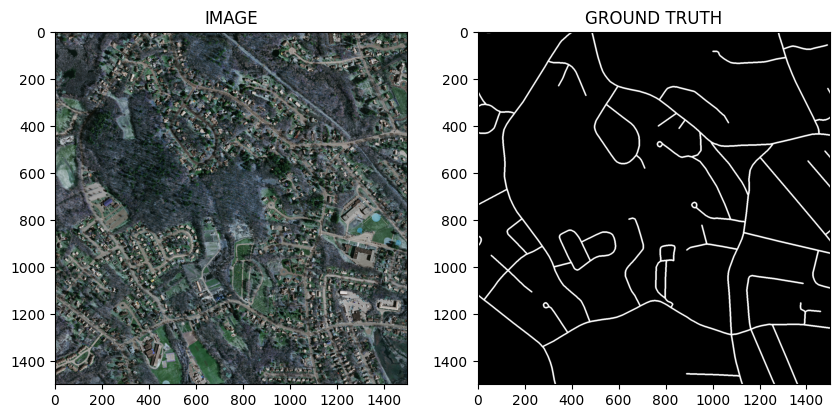

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

# Data Augmentation

In [12]:
def get_train_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(256, 256),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5)
        ])
    else:
        return A.Compose([
            A.Resize(256, 256)
        ])


# Custom Data Loader

In [34]:
class AerialSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255 
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) / 255
        mask = np.expand_dims(mask.astype(np.float32), axis=-1)

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)
        
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        return image, mask

In [40]:
train_images, val_images, train_masks, val_masks = train_test_split(
                                                                    image_paths, 
                                                                    mask_paths, 
                                                                    test_size=0.15, 
                                                                    random_state=42
                                                                    )

train_dataset = AerialSegmentationDataset(train_images, train_masks, get_train_transforms(train=True))
val_dataset = AerialSegmentationDataset(val_images, val_masks, get_train_transforms(train=False))

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

Train dataset size: 169
Validation dataset size: 30


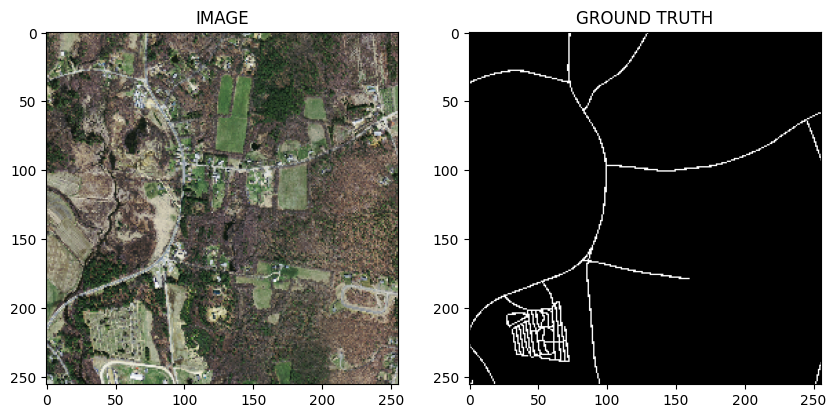

In [41]:
image_, mask_ = train_dataset[2]
helper.show_image(image_, mask_)

# Model Architecture

In [44]:
class AreialSegmentationModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = smp.Unet(
                                encoder_name="resnet18", 
                                encoder_weights="imagenet", 
                                in_channels=3, 
                                classes=1
                                )

    def forward(self, images, masks = None):
        logits = self.backbone(images)
        if masks is not None:
            loss = smp.losses.DiceLoss(mode='binary')(logits, masks) + torch.nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss
        return logits

In [47]:
model = AreialSegmentationModel()
model = model.cpu()
model

AreialSegmentationModel(
  (backbone): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

# Train the Model

In [48]:
def train_function(dataloader, model, optimizer):
    model.train()
    train_loss = []
    bar = tqdm(dataloader)
    for images, masks in bar:
        images = images.cpu()
        masks = masks.cpu()
        optimizer.zero_grad()
        _, loss = model(images, masks)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        bar.set_description(f"loss: {loss.item():.5f}")
    return np.array(train_loss).mean()

def eval_function(dataloader, model):
    model.eval()
    val_loss = []
    bar = tqdm(dataloader)
    with torch.no_grad():
        for images, masks in bar:
            images = images.cpu()
            masks = masks.cpu()
            _, loss = model(images, masks)
            
            val_loss.append(loss.item())
            bar.set_description(f"loss: {loss.item():.5f}")
    return np.array(val_loss).mean()

In [53]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
epoches = 10

In [54]:
def train_loop():
    for epoch in range(epoches):
        print(f"Epoch: {epoch+1}")
        train_loss = train_function(train_loader, model, optim)
        val_loss = eval_function(val_loader, model)
        print(f"Train loss: {train_loss:.5f}")
        print(f"Val loss: {val_loss:.5f}")
        torch.save(model.state_dict(), f"weights/model_{epoch+1}.pth")

        # write to logs.txt 
        with open('logs.txt', 'a') as f:
            f.write(f"Epoch: {epoch+1} , Train loss: {train_loss:.5f} , Val loss: {val_loss:.5f} \n")

In [55]:
train_loop()

Epoch: 1


loss: 1.40494: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Train loss: 1.23889
Val loss: 1.30191
Epoch: 2


loss: 1.05609: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Train loss: 1.04109
Val loss: 1.02267
Epoch: 3


loss: 1.10570: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Train loss: 0.98146
Val loss: 1.06511
Epoch: 4


loss: 1.01150: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 0.95833
Val loss: 0.98234
Epoch: 5


loss: 1.12778: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Train loss: 0.92154
Val loss: 1.03746
Epoch: 6


loss: 0.99127: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Train loss: 0.92385
Val loss: 0.95163
Epoch: 7


loss: 0.95099: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Train loss: 0.90037
Val loss: 0.90620
Epoch: 8


loss: 1.01335: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Train loss: 0.89688
Val loss: 0.97213
Epoch: 9


loss: 1.04154: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Train loss: 0.87189
Val loss: 0.96998
Epoch: 10


loss: 0.92325: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

Train loss: 0.86734
Val loss: 0.88472


# Inference

In [56]:
model_path = 'weights/model_10.pth'

model = AreialSegmentationModel()
model.load_state_dict(torch.load(model_path))
model.eval()

AreialSegmentationModel(
  (backbone): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [83]:
def inference(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255 
    image = cv2.resize(image, (256, 256))
    image = image.transpose(2, 0, 1)
    image = image.astype(np.float32)
    image = torch.from_numpy(image)
    image = image.unsqueeze(0)

    with torch.no_grad():
        logits = model(image.cpu())
        mask = torch.sigmoid(logits)
        mask = mask.squeeze(0).squeeze(0).cpu().numpy()
        mask = (mask > 0.5).astype(np.uint8)
        mask, image =  np.expand_dims(mask, axis=0), image.squeeze()
        mask = torch.from_numpy(mask)
        return image, mask

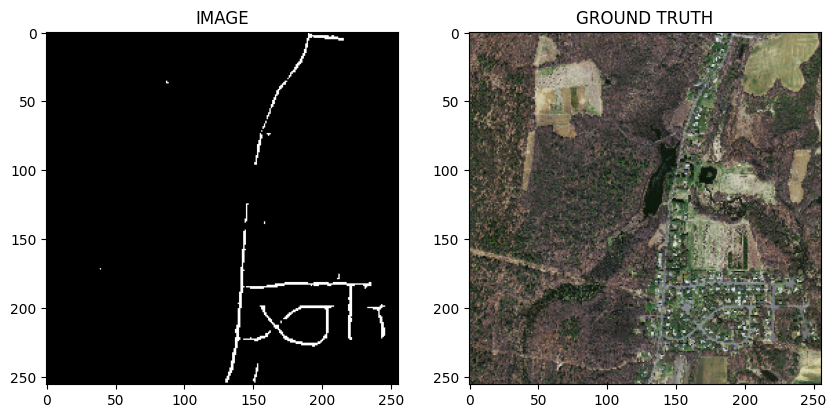

In [84]:
mask, image = inference('aerial data/images/10078675_15.png')
helper.show_image(image, mask)